In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/home/ext_navish_iitkgp_gmail_com/ganRegression/')

#### Hexagonal Level Dataset

In [2]:
import numpy as np
import os
from functools import partial
import seaborn as sns
import plotly.graph_objects as go
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
import sys
import pickle
from pathlib import Path


# hex2vec
HOME = os.environ["HOME"]

sys.path.insert(0, f"{HOME}/hex2vec")

# add codebase
sys.path.insert(0, f"/gcsmount-notebook/codebase")

from src.data.make_dataset import h3_to_polygon
import urban_tools.constants as uc
from urban_tools.hex_pipeline import RouteHexHandler, TestTrainManager
from urban_tools.pipelines import route_hex_pipeline


## Read in the Delivery DataFrame
# p = Path("/gcsmount-research-data-staging/osmnx-cities/hexed-routes/11.23.22/hh.pkl")
p = Path("/gcsmount-research-data-staging/osmnx-cities/hexed-routes/11.29.22-No-Outlier-Tags-Boston/hh.pkl")
hh = RouteHexHandler.from_pickle(p)
# embedding_df = pd.read_pickle("/gcsmount-research-data-staging/osmnx-cities/hexed-complete/Boston, MA/boston_embedding.pkl")

### Remove Super Tags
# hh.drop_super_tags()
### Remove Sub Tags
# hh = hh.drop_sub_tags()
### Filter for only H3 with > X Data Points

hh = hh.filter_hex_occurance(20)
## Drop Unecessary Columns
hh.other_tags
### Drop Chicago
# print(tagged_df.shape[0].compute(), tagged_df.shape[1])
# tagged_df = tagged_df.loc[~tagged_df["city"].str.contains("Chicago")]
# filter for only Boston
hh.df = hh.df.loc[hh.df.city.str.contains("Boston")]
hh.drop_zero_tags()
# print(tagged_df.shape[0].compute(), tagged_df.shape[1])

## Data Preprocessing: Scaling and Splitting into train test


# create a grouped dataframe
tagged_df = hh.df.groupby("h3").agg({
    "planned_service_time_log": "mean",
    **{
        tag: "first"
        for tag in hh.all_tags
    }
})


from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler

tt = TestTrainManager(
    hh.df,  # pass in the ungrouped dataframe aka raw
    x_col=hh.all_tags, 
    y_col=["planned_service_time_log"],
    # scaler=RobustScaler,
    scaler=StandardScaler,
    # scaler=MinMaxScaler,
    aggregate=True, # tell the manager to do the aggregation internally
    add_variance=True, # tell the manager to add the variance
)

tt.split_test_train()
tt.scale_test_train()
tt.build_test_df()

print(f'Training Data shape is {tt.X_train.shape}')
print(f'testing Data shape is {tt.X_test.shape}')

Aggregating Data
Training Data shape is (936, 132)
testing Data shape is (235, 132)


<AxesSubplot: >

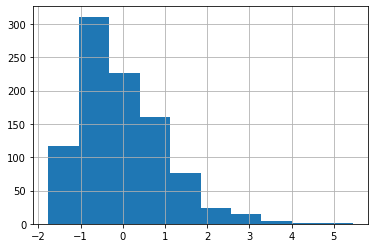

In [3]:
tt.X_train.building.hist()

#### Delievery Level Dataset

In [4]:
# import os
# import sys
# import pickle
# from pathlib import Path
# import torch; torch.manual_seed(0)
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.utils
# import torch.distributions
# import torchvision
# from torchvision import datasets, transforms
# import numpy as np
# import matplotlib.pyplot as plt
# %matplotlib inline

# from functools import partial
# import seaborn as sns
# import gc
# from numpy.random import binomial
# from numpy.random import normal

# import pandas as pd
# import seaborn as sns

# # %reset -s -f
# import os
# from functools import partial
# import logging

# # hex2vec
# HOME = os.environ["HOME"]

# sys.path.insert(0, f"{HOME}/hex2vec")

# # add codebase
# sys.path.insert(0, f"/gcsmount-notebook/codebase")

# from src.data.make_dataset import h3_to_polygon
# import urban_tools.constants as uc
# from urban_tools.hex_pipeline import RouteHexHandler, TestTrainManager
# from urban_tools.pipelines import route_hex_pipeline

# p = Path("/gcsmount-research-data-staging/osmnx-cities/hexed-routes/debug-multi-synthetic-tags/hh.pkl")
# hh = RouteHexHandler.from_pickle(p)
# # embedding_df = pd.read_pickle("/gcsmount-research-data-staging/osmnx-cities/hexed-complete/Boston, MA/boston_embedding.pkl")

# ### Filter for only H3 with > X Data Points
# hh = hh.filter_hex_occurance(20)
# ## Drop Unecessary Columns
# hh.other_tags

# ## Data Preprocessing: Scaling and Splitting into train test

# #### Create the Test-Train Manager
# # filter for only Boston
# from sklearn.preprocessing import RobustScaler
# hh.df = hh.df.loc[hh.df.city.str.contains("Boston")]
# tt = TestTrainManager(
#         hh.df,
#         scaler=RobustScaler,
#         x_col=hh.all_tags,
#         y_col=hh.df.columns.intersection(["planned_service_time_log"]),
#     )

# tt.split_test_train(random_seed=12323)
# tt.scale_test_train()
# tt.build_test_df()
# train = pd.concat([tt.X_train, tt.Y_train], axis=1, copy=True)
# test = pd.concat([tt.X_test, tt.Y_test.loc, tt.Y_test.scale], axis=1, copy=True)

# print(f'Training Data shape is {tt.X_train.shape}')
# print(f'testing Data shape is {tt.X_test.shape}')

# del hh
# gc.collect()

# # convert a pandas dataframe to a pytorch dataset
# class PandasDataset(torch.utils.data.Dataset):
#     def __init__(self, x_df, y_df):
#         self._x_df = x_df.values.astype(np.float32)
#         self._y_df = y_df.values.astype(np.float32).ravel()

#     def __len__(self):
#         return len(self._x_df)

#     def __getitem__(self, idx):
#         if torch.is_tensor(idx):
#             idx = idx.tolist()
#         return self._x_df[idx], self._y_df[idx]

In [5]:
X_train, y_train, X_test, y_test = tt.X_train.values, tt.Y_train.loc.values.ravel(), tt.X_test.values, tt.Y_test.loc.values

### 2-PCA: Let's try to understand the data itself by projecting it onto a lower dimensional space
* But first let's see the distribution of log service times

/opt/conda/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


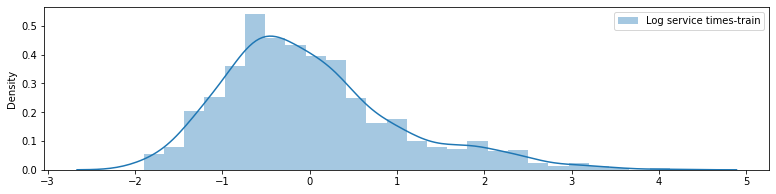

In [6]:
fig, ax = plt.subplots(figsize=(13, 3))

# TR the count is computed automatically
g = sns.distplot(x=y_train, ax=ax, label='Log service times-train')
plt.legend()

plt.show()

In [7]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import statistics as stat
from sklearn.linear_model import LinearRegression
import math
from sklearn import metrics
%matplotlib inline

In [8]:
n_components = 2
pca = PCA(n_components=n_components)

pca_df=pd.DataFrame(pca.fit_transform(X_train))
pca_df.columns=["pc1","pc2"]
pca_df["y"]= y_train

pca_df_test=pd.DataFrame(pca.transform(X_test))
pca_df_test.columns=["pc1","pc2"]
pca_df_test["y"]= y_test


pca_df.head()

,pc1,pc2,y
0,-1.915247,0.769980,-0.005270
1,-1.952630,0.685853,0.017830
2,-2.102816,0.319414,-1.195190
3,-1.685690,0.040097,-0.282150
4,-0.422765,0.271074,-0.582863


In [9]:
evr = np.cumsum(pca.explained_variance_ratio_)
print(evr)

[0.11232568 0.16304451]


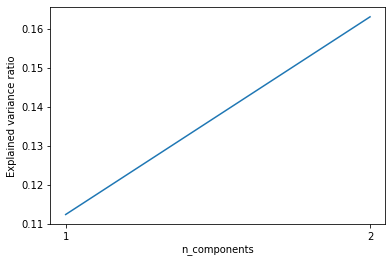

In [10]:
plt.plot(range(1,len(evr)+1),evr)
plt.xticks(range(1,len(evr)+1))
# plt.title("Explained variance ratio")
plt.ylabel("Explained variance ratio")
plt.xlabel("n_components")
plt.show()

/opt/conda/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


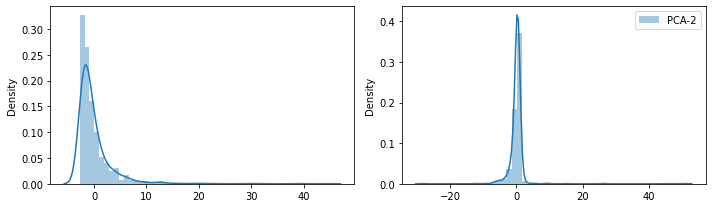

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

# TR the count is computed automatically
sns.distplot(x=pca_df['pc1'], ax=axes[0], label='PCA-1')
sns.distplot(x=pca_df['pc2'], ax=axes[1], label='PCA-2')
plt.legend()

plt.tight_layout()
plt.show()

## Simple Bayesian Linear regression using Pyro

array([[<AxesSubplot: title={'center': 'pc1'}>,
        <AxesSubplot: title={'center': 'pc2'}>],
       [<AxesSubplot: title={'center': 'y'}>, <AxesSubplot: >]],
      dtype=object)

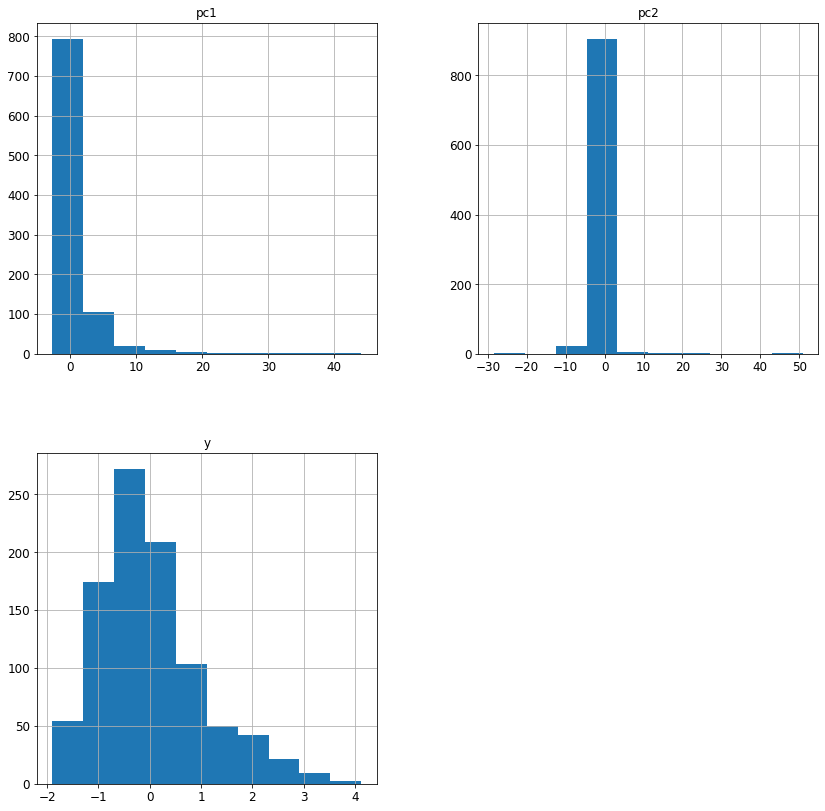

In [12]:
pca_df.hist(figsize=(14, 14),xlabelsize=12, ylabelsize=12)

44.04968881589682 50.910343652310836


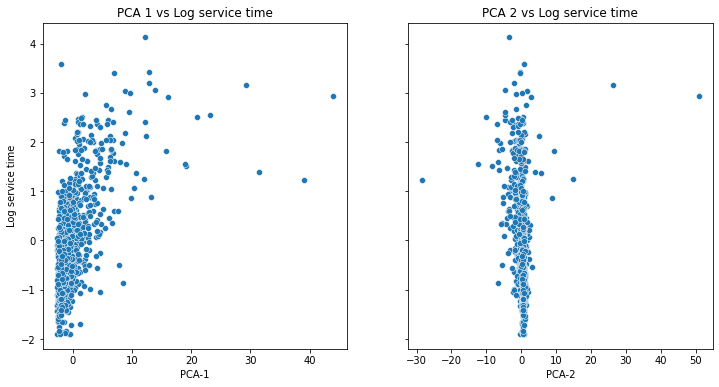

In [13]:
# Set x limits to see better the distribution

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
sns.scatterplot(x=pca_df["pc1"],
                y=pca_df["y"],
                ax=ax[0])
ax[0].set(xlabel="PCA-1", ylabel="Log service time", title="PCA 1 vs Log service time")
# ax[0].set_xlim(pca_df["pc1"].min(), pca_df["pc1"].quantile(0.75))

          
sns.scatterplot(x=pca_df["pc2"],
                y=pca_df["y"],
                ax=ax[1])
ax[1].set(xlabel="PCA-2", ylabel="Log service time", title="PCA 2 vs Log service time")
# ax[1].set_xlim(pca_df["pc2"].min(), pca_df["pc2"].quantile(0.75))

print(pca_df["pc1"].quantile(1), pca_df["pc2"].quantile(1))

In [14]:
oultier_df = tagged_df.iloc[pca_df.sort_values('pc1', ascending = False)['pc1'].index[:100]]
# oultier_df = tagged_df.iloc[pca_df.sort_values('pc2', ascending = False)['pc2'].index[:100]]
# calculate the mean of the first 100 rows
# diff_df = oultier_df - tagged_df.median()
diff_df = np.abs(oultier_df - tagged_df.mean())/tagged_df.std()

In [15]:
diff_df = pd.concat([diff_df.idxmax(axis=1), diff_df.max(axis=1)], axis=1).rename(columns={0: 'max_diff', 1: 'max_diff_value'})
diff_df['median'] = diff_df['max_diff'].map(tagged_df.median())
diff_df.reset_index(inplace=True)
diff_df['actual'] = diff_df.apply(lambda x: tagged_df.loc[x['h3'], x['max_diff']], axis=1)
diff_df.to_csv('../pca1.csv', index=False)
# diff_df.to_csv('../pca2.csv', index=False)
diff_df.head()

,h3,max_diff,max_diff_value,median,actual
0,892a306546bffff,amenity_library,17.049503,0.0,4.0
1,892a306450fffff,building_industrial,10.387705,0.0,2.0
2,892a30654d7ffff,sport_baseball,3.044105,0.0,1.0
3,892a30654afffff,highway_footway,3.629070,0.0,73.0
4,892a30654d3ffff,highway_tertiary_link,7.889915,0.0,2.0


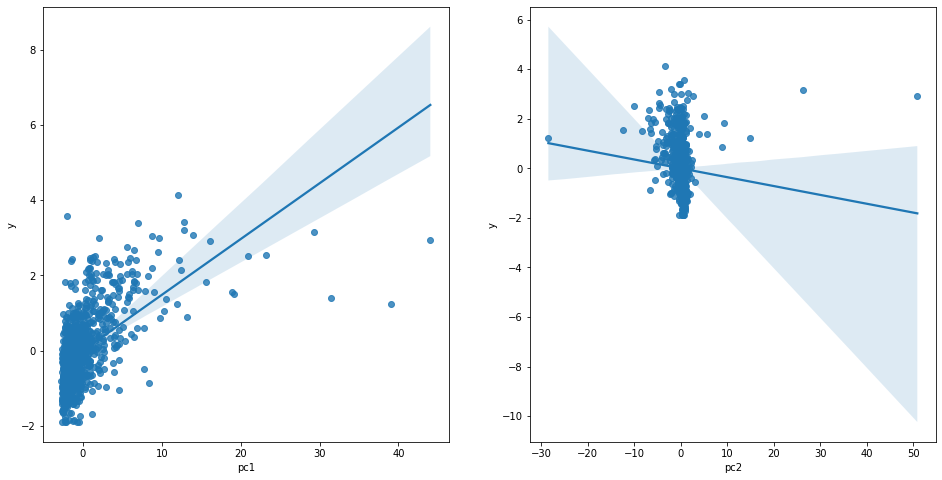

In [16]:
fig, ax = plt.subplots(round(len(pca_df.columns) / 3), 2, figsize = (16, 8))
for i, ax in enumerate(fig.axes):
    if i < len(pca_df.columns) - 1:
        sns.regplot(x=pca_df.columns[i],y='y',data=pca_df, ax=ax)

### Simple regression fitting

linear regression line: Slope = 0.15, Constant = 0.00


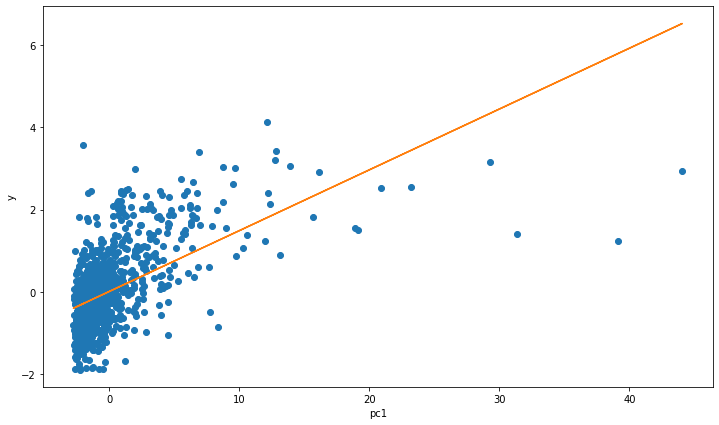

linear regression line: Slope = -0.04, Constant = 0.00


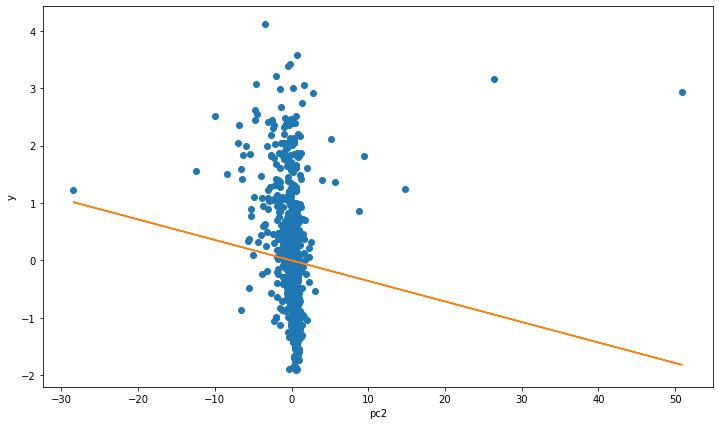

In [17]:
def regression_line(x,y):
    
    m = (sum(x*y) - (sum(x)*sum(y)/len(x)))/(sum(x*x) - (sum(x)*sum(x)/len(x)))
    constant = stat.mean(y) - m*stat.mean(x)
    print(f'linear regression line: Slope = {m:.2f}, Constant = {constant:.2f}')
    
    plt.plot(x, y, 'o')
    reg_line = [(m * i) + constant for i in x]
    plt.plot(x, reg_line)
    plt.show()

for i in pca_df.columns[:-1]:
    plt.figure(figsize=(12, 7))
    sns.scatterplot(data=pca_df, x=i, y='y', palette='cool', legend=True)
    regression_line(pca_df[i], pca_df['y'])

In [18]:
linear_regression = LinearRegression()
linear_regression.fit(X=pca_df.iloc[:,:-1].values, y=y_train)
# linear_regression.fit(X=tt.X_train[['building', 'highway']].values, y=y_train)


for i, name in enumerate(pca_df.columns[:-1]):
    print(f'{name:}: {linear_regression.coef_[i]:20.20f}')

print()
print(f'y-intercept: {linear_regression.intercept_:23.20f}')

pc1: 0.14826220730394359948
pc2: -0.03570959865268272942

y-intercept:  0.00000000000000117588


#### Creating Scatter Plots for predictions 

In [19]:
from sklearn.metrics import r2_score

def scatter_plot(y_test, y_pred, y_test_std = tt.Y_test.scale, y_pred_std = tt.Y_test.scale.values, bool = True, title = ''):
    
    plt.figure(figsize=(10, 10))
    if bool == True:
        plt.scatter(y_test, y_pred, c=y_test_std, cmap='viridis', label=f'Mean R2: {r2_score(y_test, y_pred):.2f} \n Std R2: {r2_score(y_test_std, y_pred_std):.2f}')
    else:
        plt.scatter(y_test, y_pred, c=y_pred_std, cmap='viridis', label=f'Mean R2: {r2_score(y_test, y_pred):.2f}')
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title(title)
    plt.colorbar()
    plt.legend(fontsize=20)
    plt.ticklabel_format(style='plain')
    plt.show() 

In [20]:
predicted = linear_regression.predict(pca_df_test.iloc[:,:-1].values)
# predicted = linear_regression.predict(tt.X_test[['building', 'highway']].values)

expected  = y_test

r2 = metrics.r2_score(expected, predicted)

print(f'R2 = {r2:.1f}')

R2 = 0.4


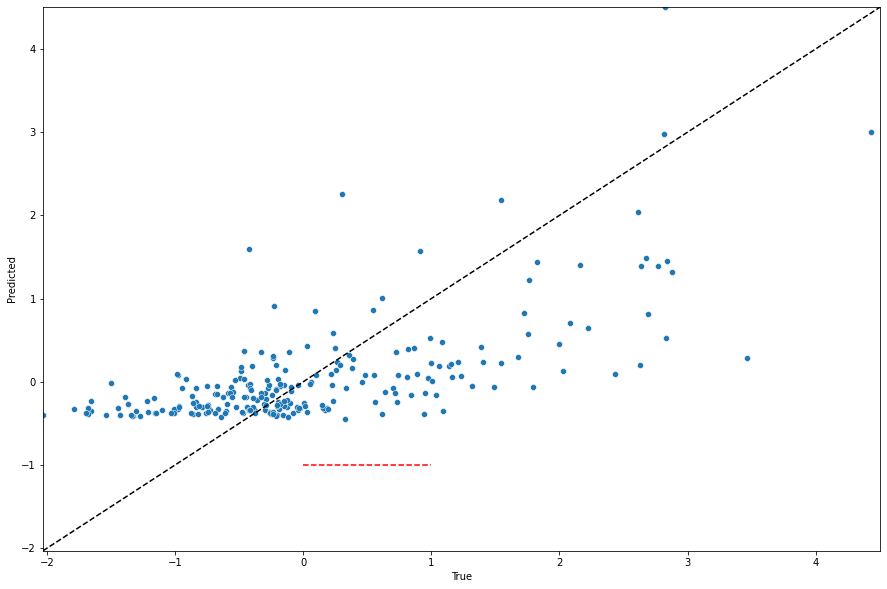

In [21]:
df = pd.DataFrame()

df['True']  = pd.Series(expected)
df['Predicted'] = pd.Series(predicted)

figure = plt.figure(figsize=(15, 10))

axes = sns.scatterplot(data=df, x='True', y='Predicted', legend=False)

start = min(expected.min(), predicted.min())
end   = max(expected.max(), predicted.max())

axes.set_xlim(start, end)
axes.set_ylim(start, end)

line = plt.plot([start, end], [start, end], 'k--')
plt.hlines(y = -1, xmin = 0, xmax = 1, color = 'r', linestyle = '--')

array([[<AxesSubplot: title={'center': 'True'}>,
        <AxesSubplot: title={'center': 'Predicted'}>]], dtype=object)

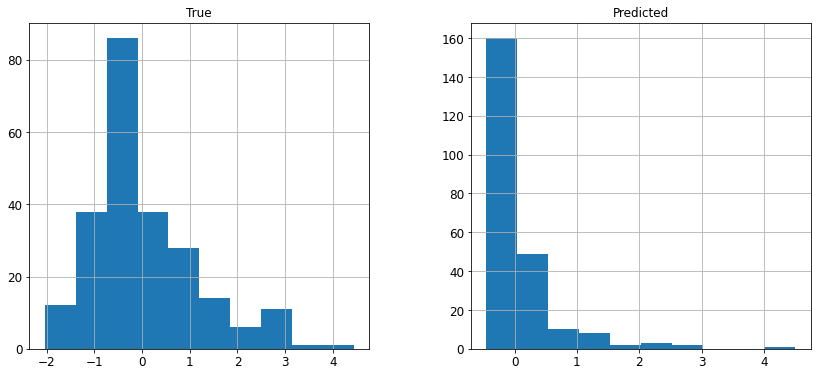

In [22]:
df.hist(figsize=(14, 6),xlabelsize=12, ylabelsize=12)

/opt/conda/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


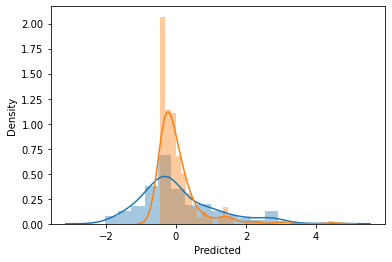

In [23]:
# create distplots
for column in df.columns:
    # plt.figure()             # <==================== here!
    sns.distplot(df[column])

#### Predicted Densities

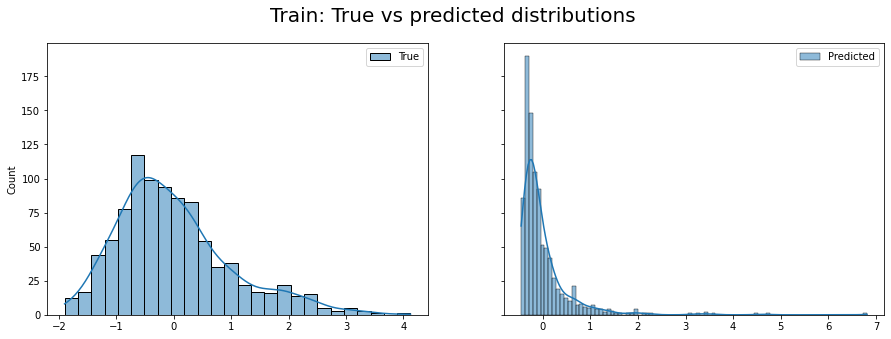

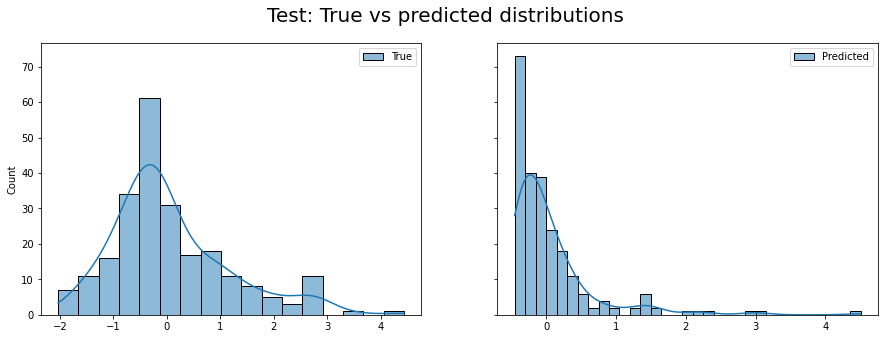

In [24]:
#  plot density of the predictions
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
fig.suptitle('Train: True vs predicted distributions', fontsize=20)


sns.histplot(y_train, ax=axes[0], kde=True, label='True')
axes[0].legend()
sns.histplot(linear_regression.predict(pca_df.iloc[:,:-1].values), ax=axes[1], kde=True, label='Predicted')
# sns.histplot(linear_regression.predict(tt.X_train[['building', 'highway']].values), ax=axes[1], kde=True, label='Predicted')
axes[1].legend()

fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
fig.suptitle('Test: True vs predicted distributions', fontsize=20)

sns.histplot(y_test, ax=axes[0], kde=True, label='True')
axes[0].legend()
sns.histplot(predicted, ax=axes[1], kde=True, label='Predicted')
axes[1].legend()

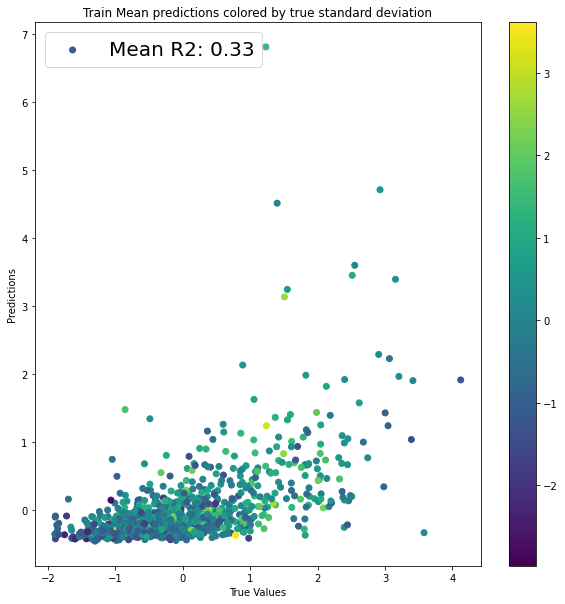

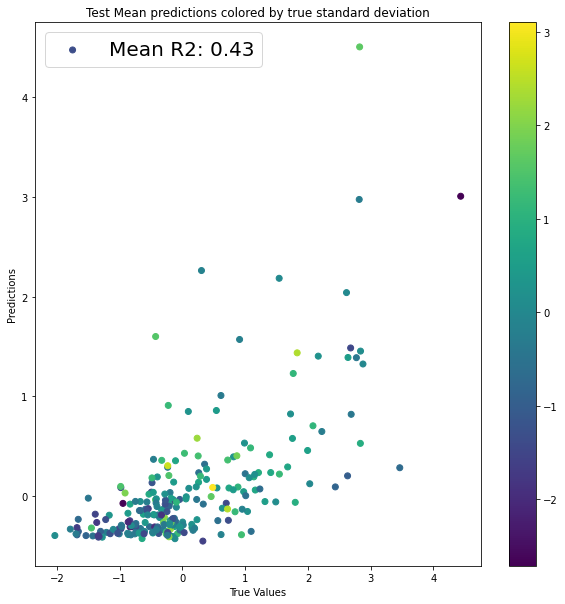

In [25]:
scatter_plot(y_train, linear_regression.predict(pca_df.iloc[:,:-1].values), y_pred_std = tt.Y_train.scale.values, bool=False, title = 'Train Mean predictions colored by true standard deviation')
scatter_plot(y_test, predicted, y_pred_std = tt.Y_test.scale.values, bool=False, title = 'Test Mean predictions colored by true standard deviation')

#### Let's try to put priors on weights using Pyro's Bayesian Linear Regression

In [26]:
# import all required Pyro/Pytorch libraries
import torch
torch.set_default_tensor_type(torch.FloatTensor) # set the default to float32

import pyro
import pyro.distributions as dist

# We will use Markov Chain Monte Carlo (MCMC) methods here, specifically the No U-Turn Sampler (NUTS)
from pyro.infer import MCMC, NUTS

In [27]:
def model_normal(X, y, column_names):
    
    # Define our intercept prior
    intercept_prior = dist.Normal(0.0, 1.0)
    linear_combination = pyro.sample(f"beta_intercept", intercept_prior)
    
    
    # Also define coefficient priors
    for i in range(X.shape[1]):
        coefficient_prior = dist.Normal(0.0, 1.0)
        beta_coef = pyro.sample(f"beta_{column_names[i]}", coefficient_prior)
        linear_combination = linear_combination + (X[:, i] * beta_coef)
    
    
    # Define a sigma prior for the random error
    sigma = pyro.sample("sigma", dist.HalfNormal(scale=1.0))
    
    # For a simple linear model, the expected mean is the linear combination of parameters
    mean = linear_combination
    
    
    with pyro.plate("data", y.shape[0]):
        
        # Assume our expected mean comes from a normal distribution with the mean which
        # depends on the linear combination, and a standard deviatin "sigma"
        outcome_dist = dist.Normal(mean, sigma)
        
        # Condition the expected mean on the observed target y
        observation = pyro.sample("obs", outcome_dist, obs=y)

In [28]:
SAMPLE_NUMBER = 3000
import time

# Turn out numpy data into PyTorch 
# tensors
X_train_torch = torch.Tensor(pca_df.iloc[:,:-1].values)
y_train_torch = torch.Tensor(pca_df.iloc[:,-1].values)


# Clear the parameter storage
pyro.clear_param_store()

# Initialize our No U-Turn Sampler
my_kernel = NUTS(model_normal, 
                 max_tree_depth=7) # a shallower tree helps the algorithm run faster

# Employ the sampler in an MCMC sampling 
# algorithm, and sample 3100 samples. 
# Then discard the first 100
my_mcmc1 = MCMC(my_kernel,
                num_samples=SAMPLE_NUMBER,
                warmup_steps=100)


# Let's time our execution as well
start_time = time.time()

# Run the sampler
my_mcmc1.run(X_train_torch, 
             y_train_torch,
             pca_df.columns[:-1])

end_time = time.time()

print()
print(f'Inference ran for {round((end_time -  start_time)/60.0, 2)} minutes')

Sample: 100%|██████████| 3100/3100 [00:56, 55.24it/s, step size=5.96e-01, acc. prob=0.912]


Inference ran for 0.94 minutes


In [29]:
my_mcmc1.summary()


                      mean       std    median      5.0%     95.0%     n_eff     r_hat
  beta_intercept     -0.00      0.03     -0.00     -0.04      0.05   3459.69      1.00
        beta_pc1      0.15      0.01      0.15      0.14      0.16   3258.20      1.00
        beta_pc2     -0.04      0.01     -0.04     -0.05     -0.02   2865.09      1.00
           sigma      0.82      0.02      0.82      0.79      0.85   2565.42      1.00

Number of divergences: 0


In [30]:
beta_df = pd.DataFrame(my_mcmc1.get_samples())
beta_df.head()

,beta_intercept,beta_pc1,beta_pc2,sigma
0,-0.093361,0.145761,-0.022980,0.823605
1,0.011497,0.154485,-0.026423,0.831051
2,0.061979,0.146480,-0.040952,0.825674
3,0.021702,0.152695,-0.052112,0.820192
4,0.010335,0.158512,-0.036567,0.829573


In [31]:
def predict_linear_combination(beta_df, X):
    
    # Don't grab the last column, that is our estimate of the error standard deviation, "sigma"
    mean_coef = beta_df.iloc[:, :-1].mean()
    # Find our linear combination again
    mean = X.dot(mean_coef[1:]) + mean_coef.iloc[0]
    std = beta_df['sigma'].mean() * np.ones(mean.shape)
    
    return mean, std

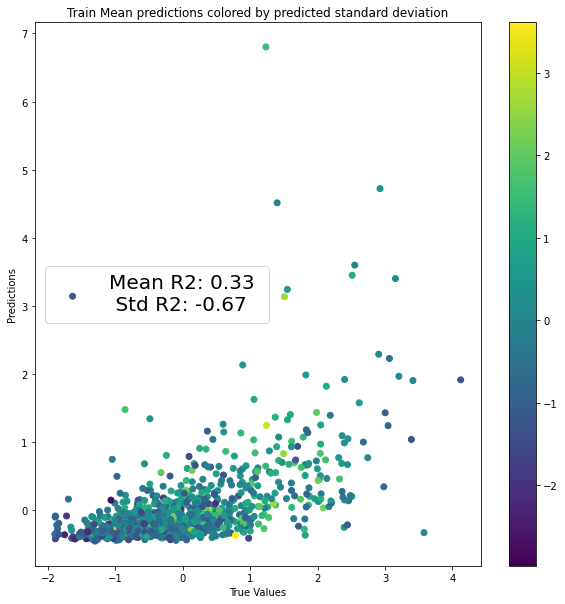

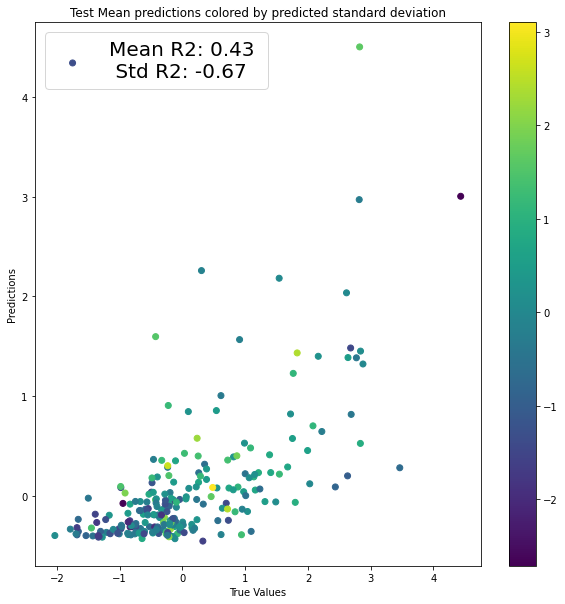

In [32]:
y_train_std, y_test_std = tt.Y_train.scale.values, tt.Y_test.scale.values

# Our predictions are the linear combination of the coefficients
y_pred_train, y_pred_std_train = predict_linear_combination(beta_df, pca_df.iloc[:,:-1].values)
scatter_plot(pca_df.iloc[:,-1].values, y_pred_train, y_train_std, y_pred_std_train, bool = True, title = 'Train Mean predictions colored by predicted standard deviation')

# Our predictions are the linear combination of the coefficients
y_pred_test, y_pred_std_test = predict_linear_combination(beta_df, pca_df_test.iloc[:,:-1].values)
scatter_plot(pca_df_test.iloc[:,-1].values, y_pred_test, y_test_std, y_pred_std_test, bool = True, title = 'Test Mean predictions colored by predicted standard deviation')

* Density Comparison

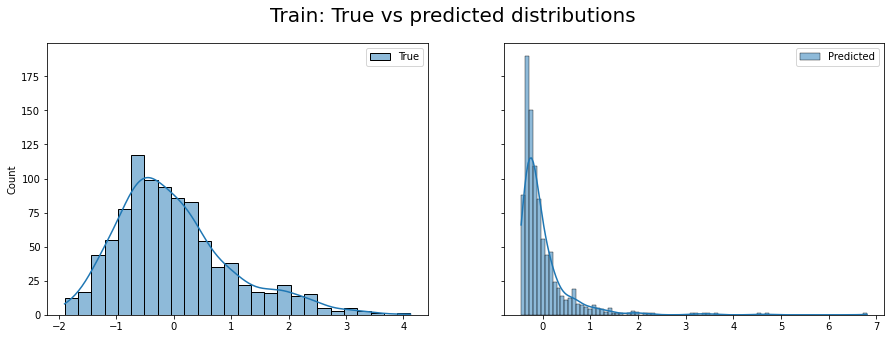

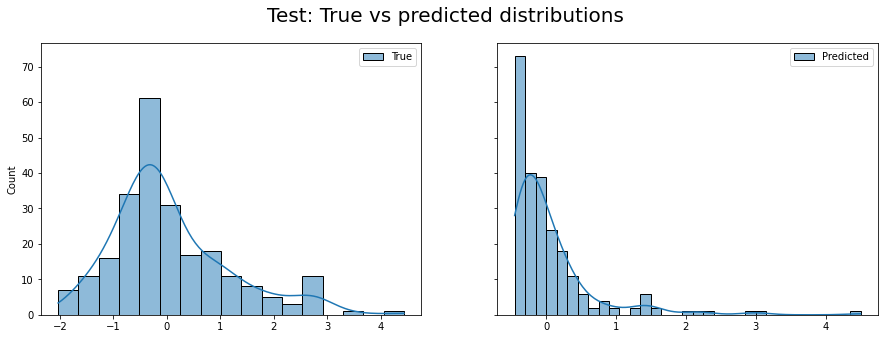

In [33]:
#  plot density of the predictions
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
fig.suptitle('Train: True vs predicted distributions', fontsize=20)

sns.histplot(y_train, ax=axes[0], kde=True, label='True')
axes[0].legend()
sns.histplot(y_pred_train, ax=axes[1], kde=True, label='Predicted')
axes[1].legend()

fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
fig.suptitle('Test: True vs predicted distributions', fontsize=20)

sns.histplot(y_test, ax=axes[0], kde=True, label='True')
axes[0].legend()
sns.histplot(y_pred_test, ax=axes[1], kde=True, label='Predicted')
axes[1].legend()

/opt/conda/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `h

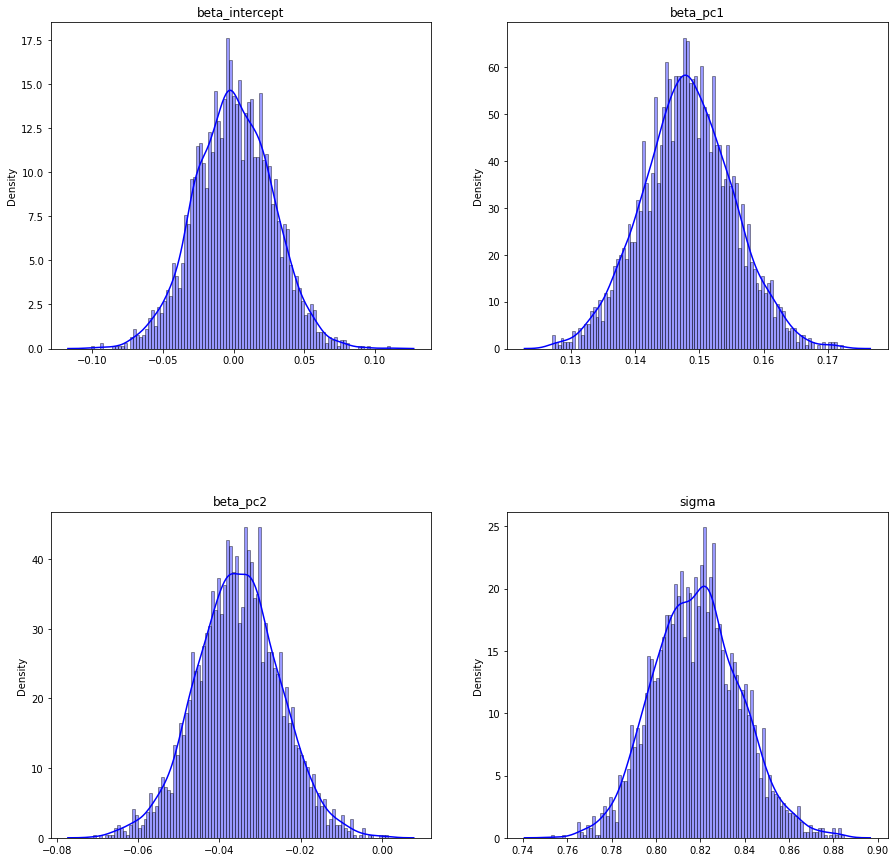

In [34]:
def draw_coefficients(beta_df):
    figure, axis = plt.subplots(2,2, figsize=(15,15))


    for key, ax in zip(beta_df.columns, axis.ravel()):
        ax.set_title(key)
        sns.distplot(beta_df[key], 
                     ax=ax, 
                     bins=100, 
                     color="blue", 
                     kde=True, 
                     axlabel=False, 
                     hist_kws=dict(edgecolor="black"))

    plt.subplots_adjust(hspace=0.5)
    plt.show()
    
draw_coefficients(beta_df)

#### Torch Loader

In [35]:
# from torch.utils.data import TensorDataset, DataLoader
# train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
# train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

# test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))
# test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

#### Modelling using GP Regression

In [36]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import numpy as np

# Make plots inline
%matplotlib inline

In [37]:
# data_dim = X_train.shape[1]

# # Same architechture as the MLP neural network
# class LargeFeatureExtractor(torch.nn.Sequential):
#     def __init__(self):
#         super(LargeFeatureExtractor, self).__init__()
#         self.add_module('linear1', torch.nn.Linear(data_dim, 16))
#         self.add_module('relu1', torch.nn.ReLU())
#         self.add_module('linear2', torch.nn.Linear(16, 32))
#         self.add_module('relu2', torch.nn.ReLU())
#         self.add_module('linear3', torch.nn.Linear(32, 128))
#         self.add_module('relu3', torch.nn.ReLU())
#         self.add_module('linear4', torch.nn.Linear(128, 32))
#         self.add_module('relu4', torch.nn.ReLU())
#         self.add_module('linear5', torch.nn.Linear(32, 16))
#         self.add_module('relu5', torch.nn.ReLU())
#         self.add_module('linear6', torch.nn.Linear(16, 2))

# feature_extractor = LargeFeatureExtractor()

In [38]:
class GPRegressionModel(gpytorch.models.ExactGP):
        def __init__(self, train_x, train_y, likelihood):
            super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
            self.mean_module = gpytorch.means.ConstantMean()
            self.covar_module = gpytorch.kernels.GridInterpolationKernel(
                gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=2)),
                num_dims=2, grid_size=256
            )
            # self.feature_extractor = feature_extractor

            # PCA based feature extractor
            self.feature_extractor = PCA(n_components=2)

            # This module will scale the NN features so that they're nice values
            self.scale_to_bounds = gpytorch.utils.grid.ScaleToBounds(-1., 1.)

        def forward(self, x):
            # We're first putting our data through a deep net (feature extractor)
            # projected_x = self.feature_extractor(x)
            projected_x = torch.Tensor(self.feature_extractor.fit_transform(x))
            projected_x = self.scale_to_bounds(projected_x)  # Make the NN values "nice"

            mean_x = self.mean_module(projected_x)
            covar_x = self.covar_module(projected_x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [39]:
# from tqdm import tqdm
# training_iterations = 1000

likelihood = gpytorch.likelihoods.GaussianLikelihood()
# model = GPRegressionModel(torch.Tensor(pca_df.iloc[:,:-1].values), torch.Tensor(y_train), likelihood)

# load the saved model
state_dict = torch.load('model_state.pth')
model = GPRegressionModel(torch.Tensor(pca_df.iloc[:,:-1].values), torch.Tensor(y_train), likelihood)  # Create a new GP model

model.load_state_dict(state_dict)

# if torch.cuda.is_available():
#     model = model
#     likelihood = likelihood

# # Find optimal model hyperparameters
# model.train()
# likelihood.train()

# # Use the adam optimizer
# optimizer = torch.optim.Adam([
#     # {'params': model.feature_extractor.parameters()},
#     {'params': model.covar_module.parameters()},
#     {'params': model.mean_module.parameters()}, 
#     {'params': model.likelihood.parameters()},
# ], lr=1e-2)

# # "Loss" for GPs - the marginal log likelihood
# mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# train_losses = []

# def train():
#     iterator = tqdm(range(training_iterations))
#     for i in iterator:
#         # Zero backprop gradients
#         optimizer.zero_grad()
#         # Get output from model
#         output = model(torch.Tensor(pca_df.iloc[:,:-1].values))
#         # Calc loss and backprop derivatives
#         loss = -mll(output, torch.Tensor(y_train))
#         loss.backward()
#         train_losses.append(loss.item())
#         iterator.set_postfix(loss=loss.item())
#         optimizer.step()

# %time train()

<All keys matched successfully>

In [41]:
# # plot the loss
# plt.plot(train_losses, label='GPRegressor-train')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

In [42]:
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.settings.fast_pred_var():
    training_preds = model(torch.Tensor(pca_df.iloc[:,:-1].values))

with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.settings.fast_pred_var():
    preds = model(torch.Tensor(pca_df_test.iloc[:,:-1].values))

/home/ext_navish_iitkgp_gmail_com/.local/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:274: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


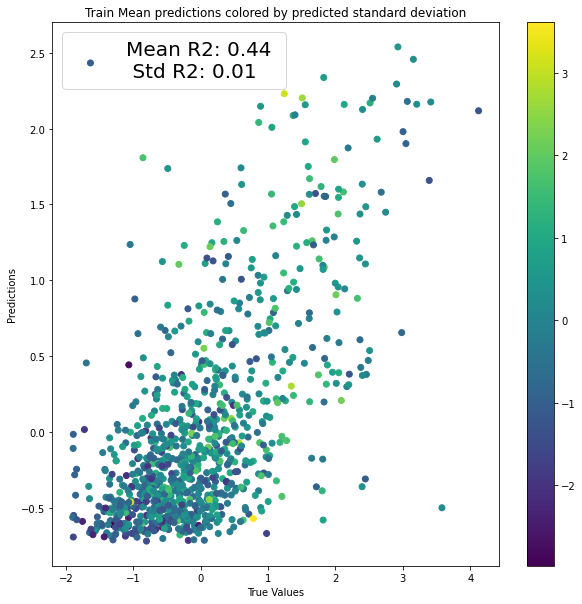

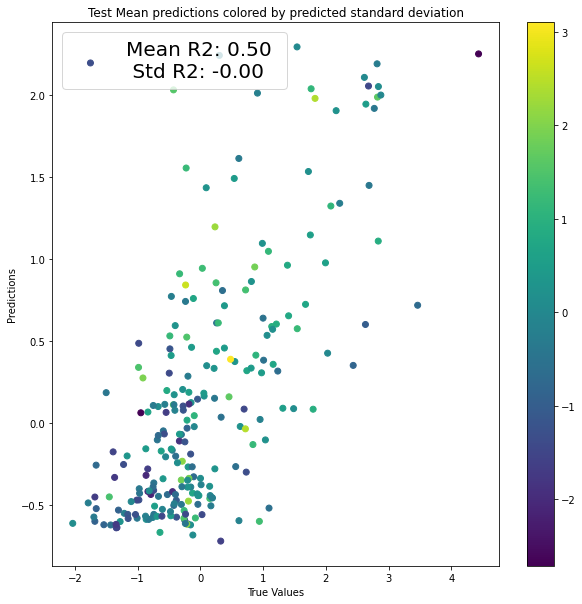

In [43]:
scatter_plot(y_train, training_preds.mean, tt.Y_train.scale, training_preds.variance**0.5, bool = True, title = 'Train Mean predictions colored by predicted standard deviation')
scatter_plot(y_test, preds.mean, tt.Y_test.scale, preds.variance**0.5, bool = True, title = 'Test Mean predictions colored by predicted standard deviation')

In [44]:
print('Mean-predicitions')
print(f'Train MAPE: {mean_absolute_percentage_error(y_train, training_preds.mean):.3f}, Train RMSE: {mean_squared_error(torch.Tensor(y_train), training_preds.mean, squared=False):.3f}, Train R2: {r2_score(torch.Tensor(y_train), training_preds.mean):.3f}')
print(f'Test MAPE: {mean_absolute_percentage_error(y_test, preds.mean):.3f}, Test RMSE: {mean_squared_error(torch.Tensor(y_test), preds.mean, squared=False):.3f}, Test R2: {r2_score(torch.Tensor(y_test), preds.mean):.3f}')
print('-'*50)
print('Variance-predicitions')
print(f'Train MAPE: {mean_absolute_percentage_error(tt.Y_train.scale, training_preds.variance**0.5):.3f}, Train RMSE: {mean_squared_error(tt.Y_train.scale, training_preds.variance**0.5, squared=False):.3f}, Train R2: {r2_score(tt.Y_train.scale, training_preds.variance**0.5):.3f}')
print(f'Test MAPE: {mean_absolute_percentage_error(tt.Y_test.scale, preds.variance**0.5):.3f}, Test RMSE: {mean_squared_error(tt.Y_test.scale, preds.variance**0.5, squared=False):.3f}, Test R2: {r2_score(tt.Y_test.scale, preds.variance**0.5):.3f}')


torch.save(model.state_dict(), 'model_state.pth')


Mean-predicitions
Train MAPE: 2.651, Train RMSE: 0.746, Train R2: 0.444
Test MAPE: 2.430, Test RMSE: 0.783, Test R2: 0.495
--------------------------------------------------
Variance-predicitions
Train MAPE: 1.804, Train RMSE: 0.997, Train R2: 0.007
Test MAPE: 1.107, Test RMSE: 1.031, Test R2: -0.002


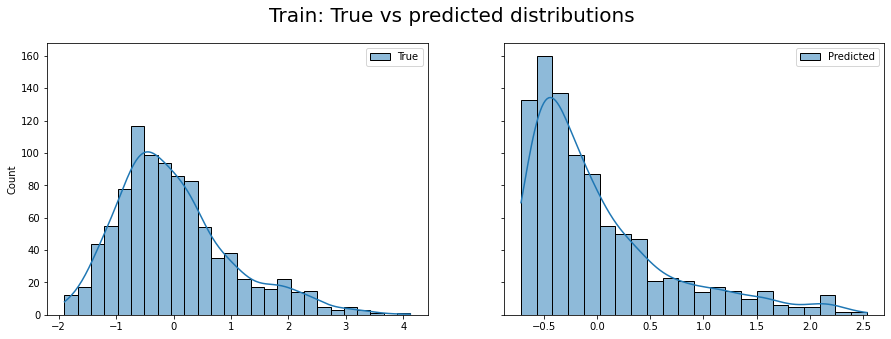

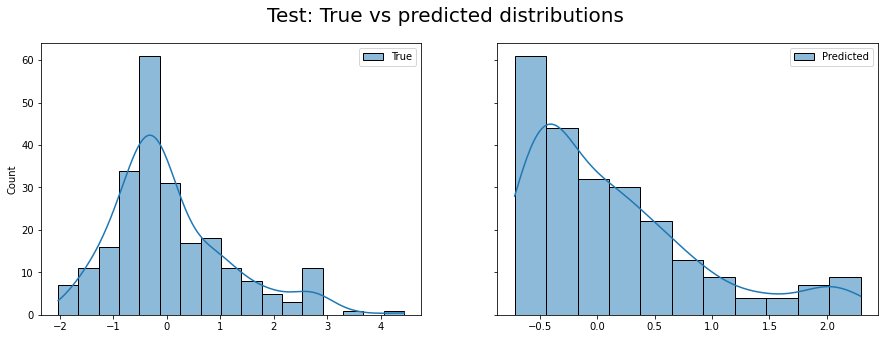

In [45]:
#  plot density of the predictions
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
fig.suptitle('Train: True vs predicted distributions', fontsize=20)

sns.histplot(y_train, ax=axes[0], kde=True, label='True')
axes[0].legend()
sns.histplot(training_preds.mean, ax=axes[1], kde=True, label='Predicted')
axes[1].legend()

fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
fig.suptitle('Test: True vs predicted distributions', fontsize=20)

sns.histplot(y_test, ax=axes[0], kde=True, label='True')
axes[0].legend()
sns.histplot(preds.mean, ax=axes[1], kde=True, label='Predicted')
axes[1].legend()

## NGBoost

NGBRegressor on PCA: 
[iter 0] loss=1.4189 val_loss=0.0000 scale=1.0000 norm=1.0000
[iter 100] loss=1.0456 val_loss=0.0000 scale=2.0000 norm=1.5071
[iter 200] loss=0.9584 val_loss=0.0000 scale=1.0000 norm=0.7423
[iter 300] loss=0.9188 val_loss=0.0000 scale=2.0000 norm=1.4702
[iter 400] loss=0.8820 val_loss=0.0000 scale=2.0000 norm=1.4454
[iter 500] loss=0.8558 val_loss=0.0000 scale=2.0000 norm=1.4282
[iter 600] loss=0.8334 val_loss=0.0000 scale=2.0000 norm=1.4129
[iter 700] loss=0.8127 val_loss=0.0000 scale=1.0000 norm=0.6982
[iter 800] loss=0.7886 val_loss=0.0000 scale=1.0000 norm=0.6882
[iter 900] loss=0.7703 val_loss=0.0000 scale=1.0000 norm=0.6820
[iter 1000] loss=0.7533 val_loss=0.0000 scale=1.0000 norm=0.6762
[iter 1100] loss=0.7367 val_loss=0.0000 scale=1.0000 norm=0.6697
[iter 1200] loss=0.7246 val_loss=0.0000 scale=1.0000 norm=0.6655
[iter 1300] loss=0.7134 val_loss=0.0000 scale=1.0000 norm=0.6619
[iter 1400] loss=0.6999 val_loss=0.0000 scale=1.0000 norm=0.6570
[iter 1500] los

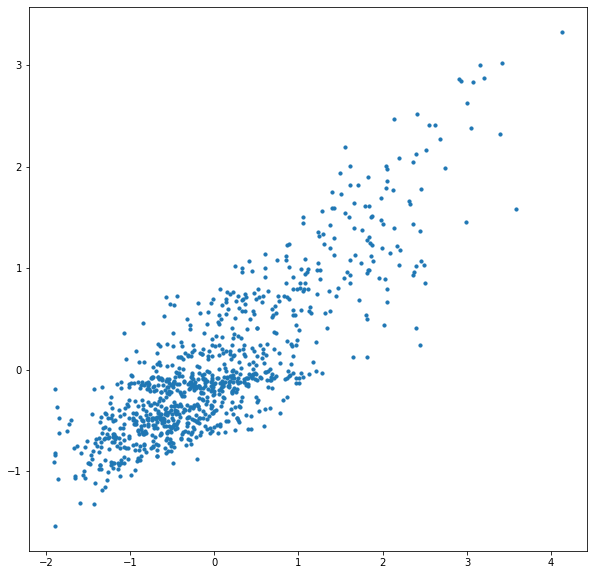

In [ ]:
from ngboost import NGBRegressor
from ngboost.learners import default_tree_learner, default_linear_learner
from ngboost.scores import CRPS, MLE
from ngboost.distns import LogNormal, Normal
print("NGBRegressor on PCA: ")

ngb = NGBRegressor(
    n_estimators=2000,
    learning_rate=0.01,
    Dist=Normal,
    Base=default_tree_learner,
    natural_gradient=True,
    # minibatch_frac=1.0,
    Score=MLE,
    # minibatch_frac=0.5, 
    # col_sample=0.5
)

ngb.fit(pca_df.iloc[:,:-1].values, y_train, )  #X_val=tt.X_test, Y_val=tt.Y_test.loc.values.ravel(), early_stopping_rounds=200)

y_pred = ngb.predict(pca_df.iloc[:,:-1].values)

MAPE = metrics.mean_absolute_percentage_error(y_train, y_pred)
R2 = metrics.r2_score(y_train, y_pred)
MSE = metrics.mean_squared_error(y_train, y_pred, squared=True)
RMSE = metrics.mean_squared_error(y_train, y_pred, squared=False)


print(f"Train MAPE: { MAPE:.2f}, R2: {R2:.2f}, MSE: {MSE:.2f}, RMSE: {RMSE:.2f}")
plt.figure(figsize=(10, 10))
plt.scatter(y_train, y_pred, s=10)

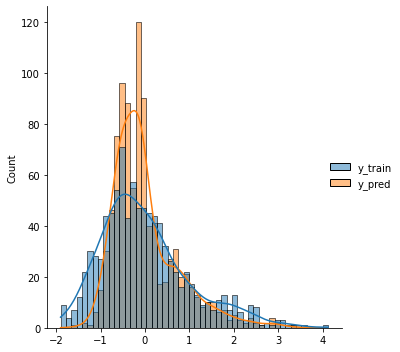

In [ ]:
import seaborn as sns

y_pred = ngb.predict(pca_df.iloc[:,:-1].values)
std_train = ngb.pred_dist(pca_df.iloc[:,:-1].values).scale

# use seaborn to plot the distribution of the predictions, on the same plot
ax = sns.displot([y_train, y_pred], kde=True, bins=50)
# name the traces
ax._legend.texts[0].set_text("y_train")
ax._legend.texts[1].set_text("y_pred")


# sns.displot(y_pred, label="Fitted Values" , ax=ax, color='r')

Test MAPE: 2.17, R2: 0.44, MSE: 0.68, RMSE: 0.82


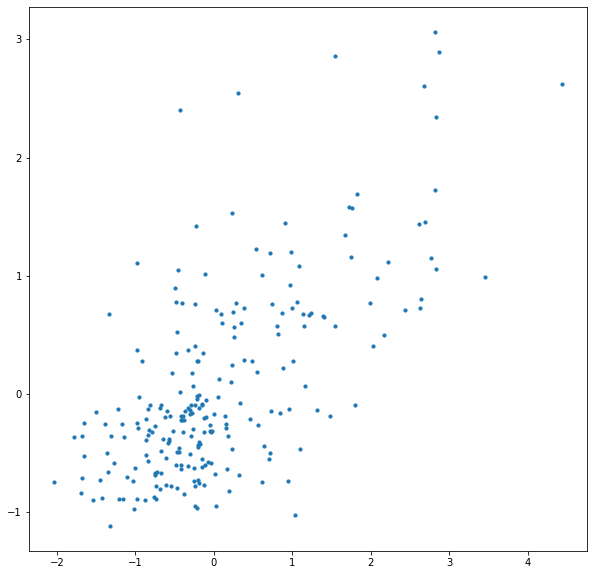

In [ ]:
y_test = tt.Y_test.loc
y_pred = ngb.predict(pca_df_test.iloc[:,:-1].values)

MAPE = metrics.mean_absolute_percentage_error(y_test, y_pred)
R2 = metrics.r2_score(y_test, y_pred)
MSE = metrics.mean_squared_error(y_test, y_pred, squared=True)
RMSE = metrics.mean_squared_error(y_test, y_pred, squared=False)

print(f"Test MAPE: {MAPE:.2f}, R2: {R2:.2f}, MSE: {MSE:.2f}, RMSE: {RMSE:.2f}")
plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_pred, s=10)

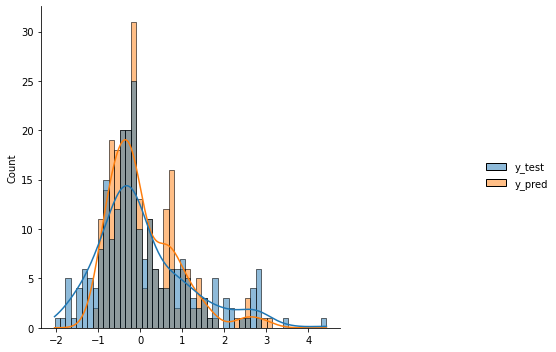

In [ ]:
import seaborn as sns

y_test = tt.Y_test.loc
y_pred = ngb.predict(pca_df_test.iloc[:,:-1].values)
std_test = ngb.pred_dist(pca_df_test.iloc[:,:-1].values).scale

# use seaborn to plot the distribution of the predictions, on the same plot
ax = sns.displot([y_test, y_pred], kde=True, bins=50)
# name the traces
ax._legend.texts[0].set_text("y_test")
ax._legend.texts[1].set_text("y_pred")


# sns.displot(y_pred, label="Fitted Values" , ax=ax, color='r')

In [ ]:
print('NGBOOST: Variance-predicitions')
print(f'Train MAPE: {mean_absolute_percentage_error(tt.Y_train.scale, std_train):.3f}, Train RMSE: {mean_squared_error(tt.Y_train.scale, std_train, squared=False):.3f}, Train R2: {r2_score(tt.Y_train.scale, std_train):.3f}')
print(f'Test MAPE: {mean_absolute_percentage_error(tt.Y_test.scale, std_test):.3f}, Test RMSE: {mean_squared_error(tt.Y_test.scale, std_test, squared=False):.3f}, Test R2: {r2_score(tt.Y_test.scale, std_test):.3f}')


NGBOOST: Variance-predicitions
Train MAPE: 8.359, Train RMSE: 1.112, Train R2: -0.236
Test MAPE: 2.377, Test RMSE: 1.141, Test R2: -0.229


## Trying to understand intra hex variance now

In [102]:
# difference between predicted and empiral distribution hexagon wise

# 1. using predictions from GP Regression model
import scipy
scipy.stats.wasserstein_distance

test_df = tt.X_test.copy()
test_df[['y_mean', 'y_std']] = tt.scaler.Y.inverse_transform(np.c_[preds.mean, preds.variance**0.5])

In [103]:
waserstein_distance = []
for group in hh.df.loc[hh.df['h3'].isin(test_df.index)].groupby('h3'):
    id_ = group[1]['h3'].tolist()[0]
    loc, scale = test_df.loc[id_][['y_mean', 'y_std']].values
    waserstein_distance.append([id_,scipy.stats.wasserstein_distance(np.random.normal(loc=loc, scale=scale, size=10), group[1]['planned_service_time_log'].to_list())])

In [106]:
test_df = test_df.join(pd.DataFrame(waserstein_distance).set_index(0)).rename(columns={1:'wasserstein_distance'})

In [111]:
largest_var_df = test_df.nlargest(100, 'wasserstein_distance')
smallest_var_df = test_df.nsmallest(100, 'wasserstein_distance')
largest_var_df.to_csv('../intrahex_largest_var_df.csv')
smallest_var_df.to_csv('../intrahex_smallest_var_df.csv')